[<img  align="right" src="https://www.gustaveroussy.fr/sites/all/themes/gustave_roussy/logo.png">](https://www.gustaveroussy.fr/)

# Create a word2vec model with all available EHR in DITEP
*This notebook does the preprocessing, the embedding and the visualisation of all EHRs*



In [3]:
# Importation of librairies

import pandas as pd
import numpy as np

import os 
from pre_process import process
from time import time
from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import get_tmpfile

import umap
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm

unable to import 'smart_open.gcs', disabling that module


In [4]:
# Load EHRs

data_dir="./Data"

df_all_ehr = pd.read_csv(os.path.join(data_dir,'df_all_CRs.csv'),sep=',',encoding="utf-8")
df_inclus = pd.read_csv(os.path.join(data_dir,'df_CRs_inclusion.csv'),sep=',',encoding="utf-8")

df_all_ehr=df_all_ehr.rename(columns={"Unnamed: 0":"index_all_CR"})
df_inclus=df_inclus.drop(columns=['CompleteValues','DATE_SIGN_OK'])

In [5]:
len(df_all_ehr)

111091

Remove Test Cohort 

In [6]:
# Merge both databases to remove test cohort from the db 'df_all_cr'
merged=pd.merge(df_all_ehr,df_inclus, on=['numCR','db'])

# Get test EHRs numbers 
df_test=merged[merged["Cohort"]=="Test"]
index_merged_test=df_test["index_all_CR"]

# Select EHRs which are not Test 
df_train_val=df_all_ehr[~df_all_ehr["index_all_CR"].isin(index_merged_test)]

Lemmatise Training and Validation set

In [7]:
df_train_val=df_train_val['value'].apply(str)

t0=time()
df_train_val=df_train_val.apply(process) 
print("{:.0f} seconds have elapsed".format(time()-t0))

# Remove empty EHRs
df_train_val = pd.DataFrame(data=df_train_val)
index_with_nan = df_train_val.index[df_train_val.isnull().any(axis=1)] 
df_train_val=df_train_val.drop(index_with_nan,0, inplace=False)
df_train_val=pd.Series(df_train_val.value)

7111 seconds have elapsed


Train and save word2vec model

In [13]:
model = Word2Vec(df_train_val, size=120, window=10, min_count=2, workers=10)
model.train(df_train_val,total_examples=len(df_train_val),epochs=10)
word_vec = model[model.wv.vocab]

model.wv.save("w2v_model.kv") # save word2vec model

Reduce dimensionnality

In [14]:
reducer = umap.UMAP(metric='cosine',random_state=42, low_memory=True)
embedded = reducer.fit_transform(word_vec)

Compute the clustering

In [15]:
# Compute the clustering

time0=time()
X_train, X_test= train_test_split(embedded,
                     test_size=0.8, random_state=42) 

AC = AgglomerativeClustering(n_clusters=300,linkage='ward')
AC.fit(X_train)
labels_AC = AC.labels_

KN = KNeighborsClassifier(n_neighbors=5)
KN.fit(X_train,labels_AC)

labels = KN.predict(embedded)
print('Il s est ecoule : {} s'.format(time()-time0))

Il s est ecoule : 6.859320402145386 s


Create figure to vizualise clusters

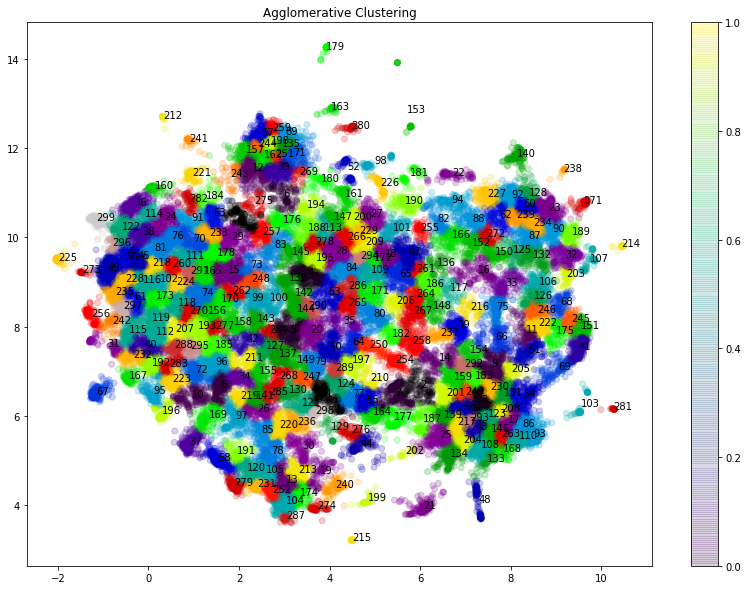

In [17]:
# Get centroids centers

embedded_DF=pd.DataFrame(data=embedded,columns=['x','y'])
embedded_DF['labels']=labels

embedded_DF=embedded_DF.groupby('labels').mean()
embedded_DF['labels']=set(labels)

# Display clusters of all EHRs

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedded[:,0],embedded[:,1], alpha=0.2,
                     c=plt.cm.nipy_spectral(labels/300))

DF_concat = pd.concat({'x': embedded_DF.x, 'y': embedded_DF.y, 'val': embedded_DF.labels}, axis=1)

for i, point in DF_concat.iterrows():

    ax.text(point['x'], point['y'], str(int(point['val'])))


ax.set_title('Agglomerative Clustering')
plt.colorbar(scatter)
plt.savefig('./Plots/Clustering')

Display similar words to : 'biopsie', 'radiographie', 'patient', 'cancer', 'essai','docteur'

In [19]:
keys = ['biopsie', 'radiographie', 'patient', 'cancer', 'essai','docteur']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(reducer.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

%matplotlib widget

plt.figure(figsize=(16, 9))
colors = cm.rainbow(np.linspace(0, 1, len(keys)))
for label, embeddings, words, color in zip(keys, embeddings_en_2d, word_clusters, colors):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    plt.scatter(x, y, c=color, alpha=0.7, label=label)

plt.legend(loc='best')
plt.title('Similar words from CR')
plt.grid(True)

plt.savefig("./Plots/similar_wordsUMAP.png", format='png', dpi=150, bbox_inches='tight')
plt.tight_layout()
plt.show()

/home/j_delorme/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/j_delorme/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [ ]:
print(word_clusters)